### **Importing necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,glob,pathlib,imutils,shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_datasets as tfds
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from tensorflow.keras.models import load_model
%matplotlib inline
plt.style.use('ggplot')

In [2]:
tf.__version__

'2.17.0'

### **Splitting the Dataset in train_dataset,test_dataset,validation_dataset**

In [2]:
image_size = (240, 240)
batch_size = 32

#Get "tensorflow.data.Dataset" object for the training data
train_dataset = image_dataset_from_directory(
    'C:/Users/ASUS/OneDrive/Documents/model_code/new_dataset/train',
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=4747,
    image_size=image_size,
    batch_size=batch_size
)

#Get "tensorflow.data.Dataset" object for the validation data
validation_dataset = image_dataset_from_directory(
    'C:/Users/ASUS/OneDrive/Documents/model_code/new_dataset/train',
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=4747,
    image_size=image_size,
    batch_size=batch_size
)

#Get "tensorflow.data.Dataset" object for the test data
test_dataset = image_dataset_from_directory(
    'C:/Users/ASUS/OneDrive/Documents/model_code/new_dataset/test',
    labels = "inferred",
    label_mode = 'int',
    seed=4747,
    image_size=image_size,
    batch_size=batch_size,
)

Found 480 files belonging to 2 classes.
Using 384 files for training.
Found 480 files belonging to 2 classes.
Using 96 files for validation.
Found 120 files belonging to 2 classes.


### Optimizing Dataset Performance

In the following code, we optimize the performance of the `train_dataset`, `validation_dataset`, and `test_dataset` using TensorFlow's data pipeline functions:
- **`cache()`**: This method caches the dataset in memory after the first epoch, reducing the time required to load the data in subsequent epochs.
- **`shuffle(buffer_size=1000)`**: Randomly shuffles the dataset with a buffer size of 1000. This ensures that the model does not learn in a fixed order, which can improve generalization.
- **`prefetch(buffer_size=tf.data.AUTOTUNE)`**: This method overlaps data preprocessing and model execution by prefetching data in the background, helping to reduce training time by preparing data while the model is training.

The `validation_dataset` and `test_dataset` are not shuffled, as these datasets should be evaluated in a consistent order.


In [3]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### **Data Augmentation**

In [4]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
    ]
)

In [5]:
inputs = tf.keras.Input(shape=(240, 240, 3))
# x = data_augmentation(inputs)
# x = tf.keras.layers.Rescaling(1./255)(x)

x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, use_bias=False)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 238, 238, 256)  │         6,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 238, 238, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 236, 236, 256)  │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 236, 236, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 236, 236, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 118, 118, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 116, 116, 256)  │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 116, 116, 256)  │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 116, 116, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 58, 58, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 256)    │       589,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,611,265 (399.06 MB)

 Trainable params: 104,609,217 (399.05 MB)

 Non-trainable params: 2,048 (8.00 KB)

### **Compile the model**

In [7]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

### **Define the callbacks**

In [8]:
callbacks = [
    # tf.keras.callbacks.EarlyStopping(patience=8),
    tf.keras.callbacks.ModelCheckpoint(filepath='C:/Users/ASUS/OneDrive/Documents/model_code/models/save_instances/baseModel.keras', save_best_only=True),
]

### **Training the Model**

In [50]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/50
 1/12 ━━━━━━━━━━━━━━━━━━━━ 33:22 182s/step - accuracy: 0.5000 - loss: 1.2636

### **Testing the accuracy of the test dataset**

In [52]:
test_model = tf.keras.models.load_model("C:/Users/ASUS/OneDrive/Documents/BrainDx/model_code/models/save_instances/EfficientNetB0.keras")

# Evaluate the model on the test dataset
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 699ms/step - accuracy: 0.8579 - loss: 0.3245
Test accuracy: 0.817


### **Confusion Matrix**

In [53]:
"""
This function makes predictions on the test data. It returns
two lists containing the true class value and predicted class
value
"""
def test_the_model():
  class_true = []
  class_pred = []

  for batch_data, batch_labels in test_dataset:

      #Make predictions
      pred_labels = test_model.predict(batch_data)

      #Convert the NumPy ndarray object to simple list
      pred_labels_np = [float(i) for i in pred_labels]

      # Convert "tf.data.Dataset" to NumPy array
      batch_labels_np = tfds.as_numpy(batch_labels)

      #Append the true and predicted labels to their respective list
      class_true.extend(batch_labels_np)
      class_pred.extend(pred_labels_np)
  return class_true, class_pred

In [54]:
#Get the true and predicted class values
class_true, class_pred = test_the_model()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


C:\Users\ASUS\AppData\Local\Temp\ipykernel_31700\3953701303.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_labels_np = [float(i) for i in pred_labels]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


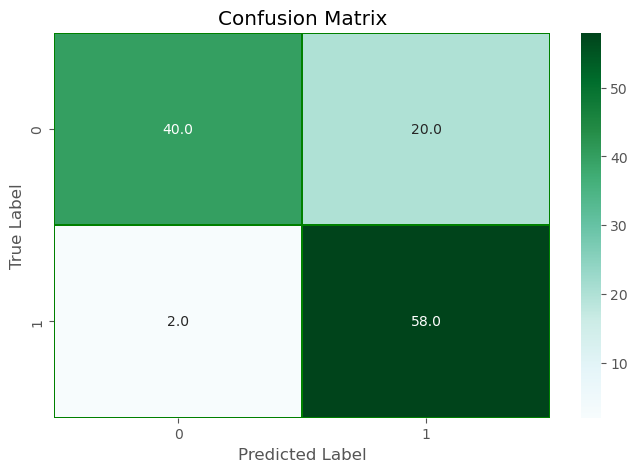

In [55]:
#Convert the predicted float values into integer values
class_pred_int = [round(i) for i in class_pred]
#Plot the confusion matrix
confusion = confusion_matrix(class_true, class_pred_int)
fig,ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion, annot=True, linewidths=0.1,
            cmap="BuGn", linecolor="green", fmt= '.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### **ROC Curve**

ROC AUC score =0.817


Text(0, 0.5, 'True Positive Rate')

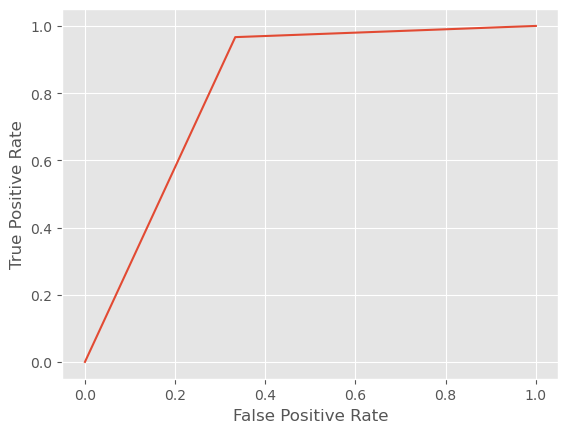

In [56]:
ROC_AUC = roc_auc_score(class_true, class_pred_int)

print('ROC AUC score =%.3f' % (ROC_AUC))

#Calculate roc curves
fpr, tpr, thresholds = roc_curve(class_true, class_pred_int)

#Plot the roc curve
plt.plot(fpr, tpr,label="AUC="+str(ROC_AUC))

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### **Classification Report**

In [57]:
# Display the classification report
class_pred_binary = [1 if pred >= 0.5 else 0 for pred in class_pred]

print(classification_report(class_true, class_pred_binary))

              precision    recall  f1-score   support

           0       0.95      0.67      0.78        60
           1       0.74      0.97      0.84        60

    accuracy                           0.82       120
   macro avg       0.85      0.82      0.81       120
weighted avg       0.85      0.82      0.81       120



### **Test Model Prediction**

In [58]:
def Test_Image_Prediction(img_path):
  image = cv2.imread(img_path)
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray_image = cv2.GaussianBlur(gray_image, (5,5), 0)

  thres = cv2.threshold(gray_image, 45, 255, cv2.THRESH_BINARY)[1]
  thres = cv2.erode(thres, None, iterations = 2)
  thres = cv2.dilate(thres, None, iterations = 2)

  cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key = cv2.contourArea)

  extLeft = tuple(c[c[:,:,0].argmin()][0])
  extRight = tuple(c[c[:,:,0].argmax()][0])
  extTop = tuple(c[c[:,:,1].argmin()][0])
  extBot = tuple(c[c[:,:,1].argmax()][0])

  new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

  new_image = cv2.resize(new_image, dsize=(240,240), interpolation = cv2.INTER_CUBIC)
  plt.imshow(new_image)

  # Check the shape of the test image
  print(new_image.shape)  # Should print (240, 240, 3)

  # Reshape the test image
  new_image = np.expand_dims(new_image, axis=0)

  # Check the new shape of the test image
  print(new_image.shape)  # Should print (1, 240, 240, 3)

  # Predict using the model
  prediction = model.predict(new_image)
  if round(prediction[0][0]) == 1:
    print('The Brain is Tumorous')
  else:
    print('The brain is non tumorous')